# Registration of Tungsten fibres on XCT images

This demo aims to demonstrate the use of [gVirtualXRay](http://gvirtualxray.sourceforge.net/) and mathematical optimisation to register polygon meshes onto X-ray microtomography (micro-CT) scans of a tungsten fiber.
 
![The fibre.](scanned_object.png)
 
For this purpose, we are using SimpleGVXR's Python wrapper and Python packages commonly used in tomography reconstruction ([Tomopy](https://tomopy.readthedocs.io/en/latest/)), image processing ([scikit-image](https://scikit-image.org/) and [SimpleITK](https://simpleitk.org/)), computer vision ([OpenCV](https://www.opencv.org/)), and non-linear numerical optimization ([CMA-ES, Covariance Matrix Adaptation Evolution Strategy](https://github.com/CMA-ES/pycma)).

## Import packages

We need to import a few libraries (called packages in Python). We use:
 
- `copy`: duplicating images using deepcopies;
- `math`: the `floor` function;
- `os`: creating a new directory
- `numpy`: who doesn't use numpy~
- `skimage`: computing the Radon transform of an image, and perform a CT reconstruction using FBP and SART;
- `tomopy`: another package for CT reconstruction;
- `SimpleITK`: image processing and saving volume data;
- OpenCV (`cv2`): Hough transform and bilateral filter (an edge-preserving smoothing filter)
- `matplotlib`: plotting data
- `cma`: non-linear numerical optimization
- `gvxrPython3`: simulation of X-ray images using the Beer-Lambert law on GPU


In [1]:
import copy, math, os

import numpy as np

from skimage.transform import radon, iradon, iradon_sart

import tomopy

import SimpleITK as sitk

import cv2

import cma

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.colors import LogNorm
from matplotlib import cm

plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

#from FlyAlgorithm import *
#from lsf import *

import gvxrPython3 as gvxr

In [2]:
if not os.path.exists("Tutorial2/outputs"):
    os.makedirs("Tutorial2/outputs");

## Global variables

We need some global variables.

- `g_reference_CT`: The reference XCT slice;
- `g_reference_sinogram`: The Radon transform of the reference XCT slice;
- `g_pixel_spacing_in_micrometre` and `g_pixel_spacing_in_mm`: The physical distance between the centre of two successive pixel;
- `g_number_of_projections`: The total number of angles in the sinogram;
- `g_angular_span_in_degrees`: The angular span covered by the sinogram;
- `g_angular_step`: the angular step; and
- `g_theta`: The rotation angles in degrees (vertical axis of the sinogram).


In [3]:
g_pixel_spacing_in_micrometre = 1.9;
g_pixel_spacing_in_mm = g_pixel_spacing_in_micrometre * 1e-3;
g_number_of_projections = 900;
g_angular_span_in_degrees = 180.0;
g_angular_step = g_angular_span_in_degrees / g_number_of_projections;
g_theta = np.linspace(0., g_angular_span_in_degrees, g_number_of_projections, endpoint=False);

## Load the image data

Load and display the reference projections from a raw binary file, i.e. the target of the registration.

In [4]:
# Target of the registration
reference_normalised_projections = np.fromfile("Tutorial2/sino.raw", dtype=np.float32);
reference_normalised_projections.shape = [g_number_of_projections, int(reference_normalised_projections.shape[0] / g_number_of_projections)];

In [5]:
#np.savetxt("Tutorial2/outputs/reference_sinogram.txt", reference_normalised_projections);
volume = sitk.GetImageFromArray(reference_normalised_projections);
volume.SetSpacing([g_pixel_spacing_in_mm, g_angular_step, g_pixel_spacing_in_mm]);
sitk.WriteImage(volume, 'Tutorial2/outputs/reference_normalised_projections.mha', useCompression=True);

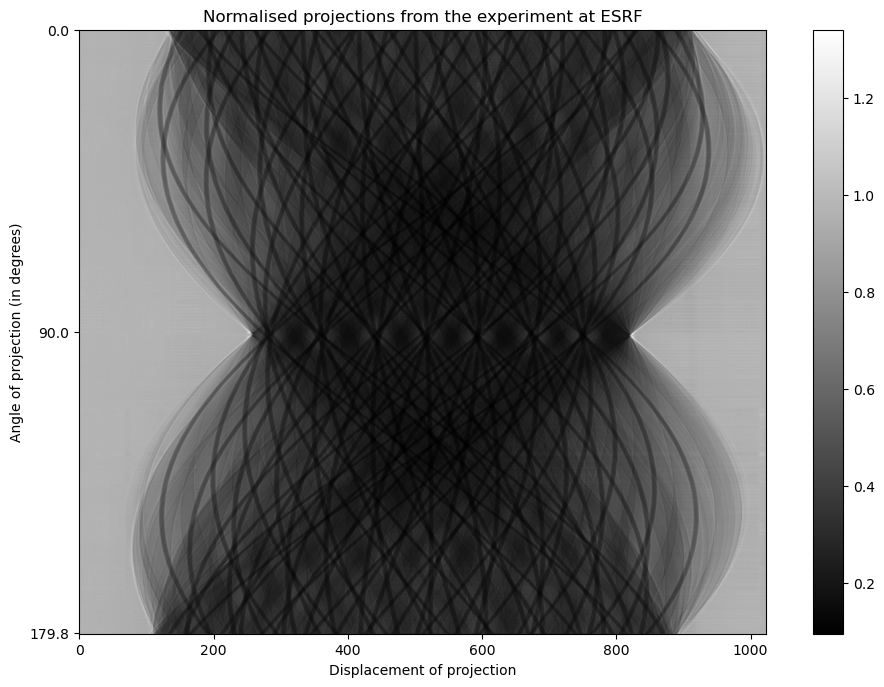

In [6]:
labels=[g_theta[0], g_theta[reference_normalised_projections.shape[0] // 2], g_theta[-1]];
tics=[0, reference_normalised_projections.shape[0] // 2, reference_normalised_projections.shape[0]-1];
fig=plt.figure();
imgplot = plt.imshow(reference_normalised_projections, cmap="gray");
plt.xlabel("Displacement of projection");
plt.ylabel("Angle of projection (in degrees)");
plt.yticks(tics, labels);
plt.title("Normalised projections from the experiment at ESRF");
fig.colorbar(imgplot);

In the literature, a projection is often modelled as follows:

$$P = \ln\left(\frac{I_0}{I}\right) = -\ln\left(\frac{I}{I_0}\right) = \sum_n \mu(n) \Delta_x$$


`reference_normalised_projections` loaded from the binary file corresponds to $\frac{I}{I_0}$. The flat-field correction has already been performed. It is now necessary to linearise the transmission tomography data using:

$$-\ln(normalised\_projections)$$ 

This new image corresponds to the Radon transform, known as sinogram, of the scanned object in these experimental conditions. Once this is done, we divide the pixels of the sinogram by $\Delta_x$, which is egal to the spacing between two successive pixels along the horizontal axis.

We define a new function to compute the sinogram from flat-field correction and calls it straightaway.

In [7]:
def computeSinogramFromFlatField(normalised_projections):
    simulated_sinogram = -np.log(normalised_projections);
    simulated_sinogram /= g_pixel_spacing_in_micrometre * gvxr.getUnitOfLength("um") / gvxr.getUnitOfLength("cm");

    return simulated_sinogram;

In [8]:
g_reference_sinogram = computeSinogramFromFlatField(reference_normalised_projections);

In [9]:
#np.savetxt("Tutorial2/outputs/reference_sinogram.txt", g_reference_sinogram);
volume = sitk.GetImageFromArray(g_reference_sinogram);
volume.SetSpacing([g_pixel_spacing_in_mm, g_angular_step, g_pixel_spacing_in_mm]);
sitk.WriteImage(volume, 'Tutorial2/outputs/reference_sinogram.mha', useCompression=True);

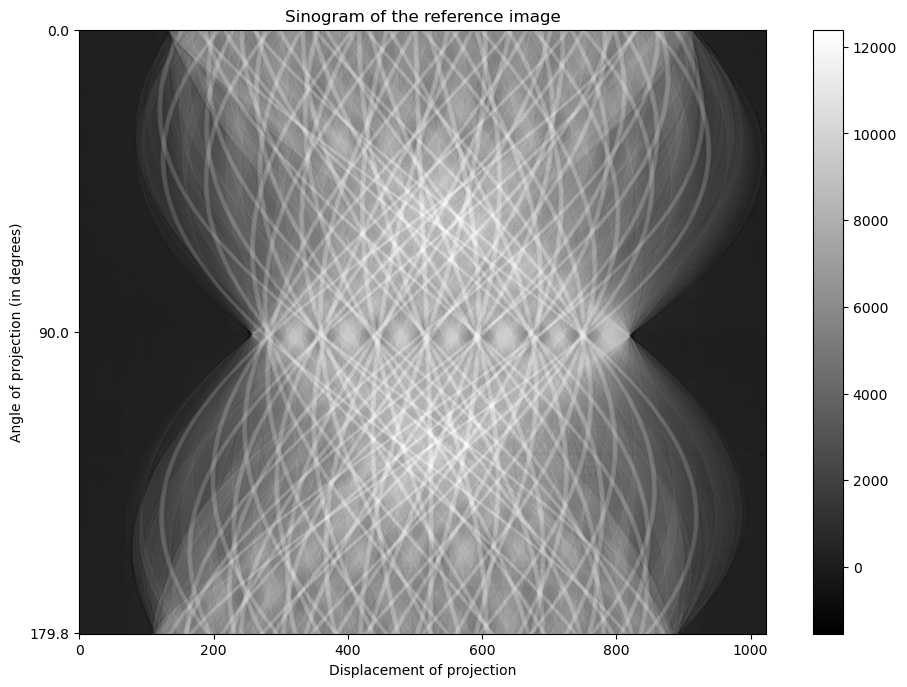

In [10]:
labels=[g_theta[0], g_theta[g_reference_sinogram.shape[0] // 2], g_theta[-1]];
tics=[0, g_reference_sinogram.shape[0] // 2, g_reference_sinogram.shape[0]-1];
fig=plt.figure();
imgplot = plt.imshow(g_reference_sinogram, cmap="gray");
plt.xlabel("Displacement of projection");
plt.ylabel("Angle of projection (in degrees)");
plt.yticks(tics, labels);
plt.title("Sinogram of the reference image");
fig.colorbar(imgplot);

## CT reconstruction

Now we got a sinogram, we can reconstruct the CT slice. As we used a synchrotron, we can assume we have a parallel source. It means we can use a FBP rather than the FDK algorithm.

In [11]:
g_reference_CT = iradon(g_reference_sinogram.T, theta=g_theta, circle=True);

In [12]:
#np.savetxt("Tutorial2/outputs/reference_CT.txt", g_reference_CT);
volume = sitk.GetImageFromArray(g_reference_CT);
volume.SetSpacing([g_pixel_spacing_in_mm, g_angular_step, g_pixel_spacing_in_mm]);
sitk.WriteImage(volume, 'Tutorial2/outputs/reference_CT.mha', useCompression=True);

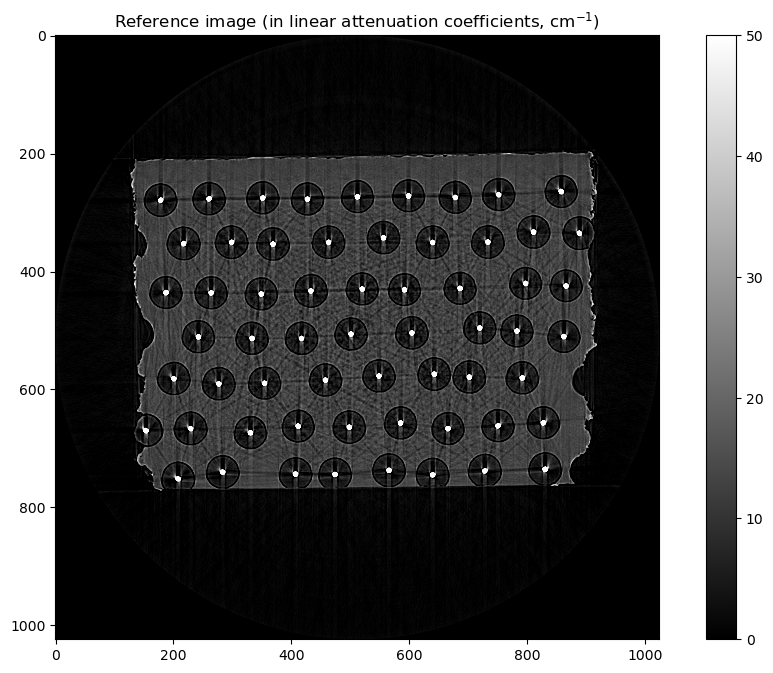

In [13]:
fig=plt.figure();
norm = cm.colors.Normalize(vmax=50, vmin=0)
imgplot = plt.imshow(g_reference_CT, cmap="gray", norm=norm);
fig.colorbar(imgplot);
plt.title("Reference image (in linear attenuation coefficients, cm$^{-1}$)");

## Set the X-ray simulation environment

First we create an OpenGL context, here using EGL, i.e. no window.

In [14]:
gvxr.createWindow(0, 1, "EGL");
gvxr.setWindowSize(512, 512);

We set the parameters of the X-ray detector (flat pannel), e.g. number of pixels, pixel, spacing, position and orientation:

![3D scene to be simulated using gVirtualXray](3d_scene.png)

In [15]:
detector_width_in_pixels = g_reference_sinogram.shape[1];
detector_height_in_pixels = 1;
distance_object_detector_in_m =    0.08; # = 80 mm

gvxr.setDetectorPosition(-distance_object_detector_in_m, 0.0, 0.0, "m");
gvxr.setDetectorUpVector(0, 1, 0);
gvxr.setDetectorNumberOfPixels(detector_width_in_pixels, detector_height_in_pixels);
gvxr.setDetectorPixelSize(g_pixel_spacing_in_micrometre, g_pixel_spacing_in_micrometre, "micrometer");

The beam specturm. Here we have a polychromatic beam, with 97% of the photons at 33 keV, 2% at 66 keV and 1% at 99 keV.

In [16]:
energy_spectrum = [(33, 0.97, "keV"), (66, 0.02, "keV"), (99, 0.01, "keV")];

for energy, percentage, unit in energy_spectrum:
    gvxr.addEnergyBinToSpectrum(energy, unit, percentage);

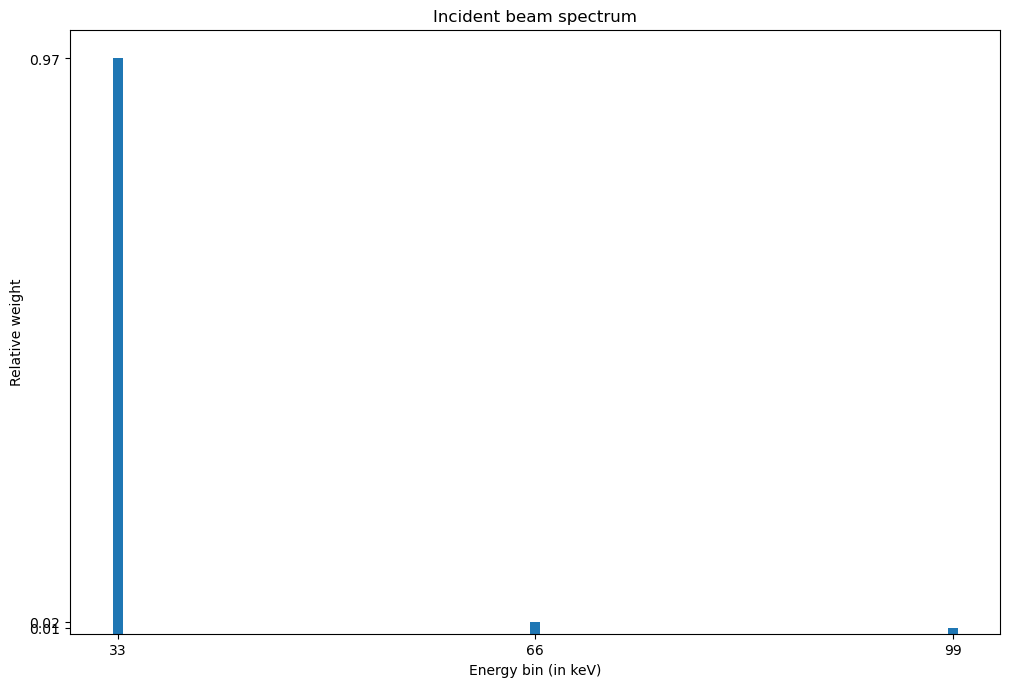

In [17]:
energies_in_keV = [];
weights = [];

for energy, percentage, unit in energy_spectrum:
    weights.append(percentage);
    energies_in_keV.append(energy * gvxr.getUnitOfEnergy(unit) / gvxr.getUnitOfEnergy("keV"));

fig=plt.figure();
plt.xlabel("Energy bin (in keV)");
plt.ylabel("Relative weight");
plt.xticks(energies_in_keV);
plt.yticks(weights);
plt.title("Incident beam spectrum");
plt.bar(energies_in_keV, weights);

And the source parameters (beam shape, source position)

In [18]:
# Set up the beam
distance_source_detector_in_m  = 145.0;

gvxr.setSourcePosition(distance_source_detector_in_m - distance_object_detector_in_m,  0.0, 0.0, "mm");
gvxr.usePointSource();
gvxr.useParallelBeam();

The material properties (chemical composition and density)

In [19]:
fiber_radius = 140 / 2; # um
fiber_material = [("Si", 0.5), ("C", 0.5)];
fiber_mu = 2.736; # cm-1
fiber_density = 3.2; # g/cm3

core_radius = 30 / 2; # um
core_material = [("W", 1)];
core_mu = 341.61; # cm-1
core_density = 19.3 # g/cm3

g_matrix_width = 0;
g_matrix_height = 0;
g_matrix_x = 0;
g_matrix_y = 0;
matrix_material = [("Ti", 0.9), ("Al", 0.06), ("V", 0.04)];
matrix_mu = 13.1274; # cm-1
matrix_density = 4.42 # g/cm3

## Registration of a cube

## Normalise the image data

Zero-mean unit-variance normalisation is applied to use the reference images in objective functions and perform the registration. Note that it is called standardisation (Z-score Normalisation) in machine learning. It is computed as follows:

$$I' = \frac{I - \bar{I}}{\sigma}$$

Where $I'$ is the image after the original image $I$ has been normalised, $\bar{I}$ is the average pixel value of $I$, and $\sigma$ is its standard deviation.

In [21]:
normalised_reference_sinogram = (g_reference_sinogram - g_reference_sinogram.mean()) / g_reference_sinogram.std();
normalised_reference_CT       = (g_reference_CT       - g_reference_CT.mean())       / g_reference_CT.std();

In [39]:
#np.savetxt("outputs/normalised_reference_sinogram.txt", normalised_reference_sinogram);
volume = sitk.GetImageFromArray(normalised_reference_sinogram);
volume.SetSpacing([g_pixel_spacing_in_mm, g_angular_step, g_pixel_spacing_in_mm]);
sitk.WriteImage(volume, "Tutorial2/outputs/normalised_reference_sinogram.mha", useCompression=True);

#np.savetxt("outputs/normalised_reference_CT.txt", normalised_reference_CT);
volume = sitk.GetImageFromArray(normalised_reference_CT);
volume.SetSpacing([g_pixel_spacing_in_mm, g_pixel_spacing_in_mm, g_pixel_spacing_in_mm]);
sitk.WriteImage(volume, "Tutorial2/outputs/normalised_reference_CT.mha", useCompression=True);

In [23]:
def setMatrix(apGeneSet):

    gvxr.removePolygonMeshesFromXRayRenderer();

    # Matrix
    # Make a cube
    gvxr.makeCube("matrix", 1.0, "micrometer");

    # Translation vector
    x = apGeneSet[0] * detector_width_in_pixels * g_pixel_spacing_in_micrometre;
    y = apGeneSet[1] * detector_width_in_pixels * g_pixel_spacing_in_micrometre;

    gvxr.translateNode("matrix", x, 0.0, y, "micrometer");

    # Rotation angle
    rotation_angle_in_degrees = (apGeneSet[2] + 0.5) * 360.0;
    gvxr.rotateNode("matrix", rotation_angle_in_degrees, 0, 1, 0);
    
    # Scaling factors
    w = (apGeneSet[3] + 0.5) * detector_width_in_pixels * g_pixel_spacing_in_micrometre;
    h = (apGeneSet[4] + 0.5) * detector_width_in_pixels * g_pixel_spacing_in_micrometre;    
    gvxr.scaleNode("matrix", w, 815, h);

#     print("w:", w, "h:", h, "x:", x, "y:", y);

    # Apply the transformation matrix so that we can save the corresponding STL file
    gvxr.applyCurrentLocalTransformation("matrix");

    # Matrix
    gvxr.setMixture("matrix", "Ti90Al6V4");
    gvxr.setDensity("matrix", matrix_density, "g/cm3");

    gvxr.addPolygonMeshAsOuterSurface("matrix");

### Simulate the CT acquisition

Compute the raw projections and save the data. For this  purpose, we define a new function.

In [25]:
def tomographyAcquisition():
    raw_projections_in_MeV = [];

    for angle_id in range(0, g_number_of_projections):
        gvxr.resetSceneTransformation();
        gvxr.rotateScene(-g_angular_step * angle_id, 0, 1, 0);
        raw_projections_in_MeV.append(gvxr.computeXRayImage());

    raw_projections_in_MeV = np.array(raw_projections_in_MeV);
    raw_projections_in_keV = raw_projections_in_MeV / gvxr.getUnitOfEnergy("keV");
    
    return raw_projections_in_keV;

### Flat-filed correction

Because the data suffers from a fixed-pattern noise in X-ray imaging in actual experiments, it is necessary to perform the flat-field correction of the raw projections using:

$$normalised\_projections = \frac{raw\_projections − dark\_field}{flat\_field\_image − dark\_field}$$

- $raw\_projections$ are the raw projections with the X-ray beam turned on and with the scanned object, 
- $flat\_field\_image$ is an image with the X-ray beam turned on but without the scanned object, and 
- $dark\_field$ is an image with the X-ray beam turned off.

Note that in our example, $raw\_projections$, $flat\_field\_image$ and $dark\_field$ are in keV whereas $normalised\_projections$ does not have any unit:

$$0 \leq raw\_projections \leq  \sum_E N_0(E) \times E\\0 \leq normalised\_projections \leq 1$$

We define a new function to compute the flat-field correction.

In [27]:
def flatFieldCorrection(raw_projections_in_keV):
    dark_field_image = np.zeros(raw_projections_in_keV.shape);
    flat_field_image = np.zeros(raw_projections_in_keV.shape);

    # Retrieve the total energy
    total_energy = 0.0;
    energy_bins = gvxr.getEnergyBins("keV");
    photon_count_per_bin = gvxr.getPhotonCountEnergyBins();

    for energy, count in zip(energy_bins, photon_count_per_bin):
        total_energy += energy * count;
    flat_field_image = np.ones(raw_projections_in_keV.shape) * total_energy;

    normalised_projections = (raw_projections_in_keV - dark_field_image) / (flat_field_image - dark_field_image);
    
    return normalised_projections;

In [28]:
def simulateSinogram():
    raw_projections_in_keV = tomographyAcquisition();
    normalised_projections = flatFieldCorrection(raw_projections_in_keV);
    simulated_sinogram = computeSinogramFromFlatField(normalised_projections);
    return simulated_sinogram, normalised_projections, raw_projections_in_keV;

In [46]:
def fitnessFunction(x):
    global best_fitness, matrix_id;
    setMatrix(x);
    
    # Simulate a sinogram
    simulated_sinogram, normalised_projections, raw_projections_in_keV = simulateSinogram();
    normalised_simulated_sinogram = (simulated_sinogram - simulated_sinogram.mean()) / simulated_sinogram.std();

    # reconstruct the CT slice
    theta = g_theta / 180.0 * math.pi;
    rot_center = int(simulated_sinogram.shape[2]/2);
    reconstruction_tomopy = tomopy.recon(simulated_sinogram, theta, center=rot_center, algorithm="gridrec", sinogram_order=False);
    normalised_simulated_CT = (reconstruction_tomopy - reconstruction_tomopy.mean()) / reconstruction_tomopy.std();
    
#     print(normalised_simulated_sinogram.shape, normalised_simulated_sinogram.shape);
    #MAE = np.mean(np.abs(normalised_simulated_image - g_reference_sinogram));
    #ZNCC = np.mean(np.multiply(normalised_simulated_image, g_reference_sinogram));
    
    # Compute the fitness function
    MAE = np.mean(np.abs(normalised_simulated_CT - normalised_reference_CT));
    ZNCC = np.mean(np.multiply(normalised_simulated_CT, normalised_reference_CT));
    
    # Save the data
    fitness = abs(1/ ZNCC)
    if best_fitness > fitness:
        best_fitness = fitness;
        
        gvxr.saveSTLfile("matrix", "Tutorial2/outputs/matrix_" + str(matrix_id) + ".stl");
        
        #np.savetxt("outputs/reconstruction_gvxr_fbp.txt", reconstruction_fbp);
        
        normalised_simulated_sinogram.shape = (normalised_simulated_sinogram.size//normalised_simulated_sinogram.shape[2], normalised_simulated_sinogram.shape[2]);
        
        volume = sitk.GetImageFromArray(normalised_simulated_sinogram);
        volume.SetSpacing([g_pixel_spacing_in_mm, g_angular_step, g_pixel_spacing_in_mm]);
        sitk.WriteImage(volume, "Tutorial2/outputs/normalised_simulated_sinogram_" + str(matrix_id) + ".mha", useCompression=True);

        volume = sitk.GetImageFromArray(normalised_simulated_CT);
        volume.SetSpacing([g_pixel_spacing_in_mm, g_pixel_spacing_in_mm, g_pixel_spacing_in_mm]);
        sitk.WriteImage(volume, "Tutorial2/outputs/normalised_simulated_CT_" + str(matrix_id) + ".mha", useCompression=True);

        np.savetxt("Tutorial2/outputs/cube_" + str(matrix_id) + ".dat", x, header='x,y,rotation_angle,w,h');

        matrix_id += 1;
        
#     best_fitness = min(MAE, best_fitness);
        print("Best:", best_fitness, "MAE:", MAE, "ZNCC:", "%.2f" % (100*ZNCC) + "%")
    
    return fitness;

In [47]:
best_fitness = sys.float_info.max;
matrix_id = 0;

opts = cma.CMAOptions()
print(opts['tolfun'])
print(opts['tolx'])

opts.set('tolfun', 1e-4);
opts['tolx'] = 1e-4;
opts['bounds'] = [5*[-0.5], 5*[0.5]];

es = cma.CMAEvolutionStrategy(5 * [0], 0.5, opts);
es.optimize(fitnessFunction);

1e-11  #v termination criterion: tolerance in function value, quite useful
1e-11  #v termination criterion: tolerance in x-changes
(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 5 (seed=774033, Thu Jan 14 17:06:26 2021)
Reconstructing 1 slice groups with 1 master threads...
Best: 8.467078769263845 MAE: 0.6863062 ZNCC: 11.81%
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Best: 3.9523588696592338 MAE: 0.6987939 ZNCC: 25.30%
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      8 3.952358869659234e+00 1.0e+00 4.31e-01  4e-01  4e-01 0:06.5
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with

Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstruc

Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
   35    280 3.407444206028196e+00 6.6e+00 6.52e-02  2e-02  9e-02 3:10.4
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master thr

Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
   51    408 3.138977726492232e+00 4.5e+00 2.68e-02  6e-03  2e-02 4:42.9
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master thr

Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Best: 3.0934299892532486 MAE: 0.59556097 ZNCC: 32.33%
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstruct

Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
   86    688 3.084747364521173e+00 6.8e+00 4.10e-03  3e-04  1e-03 7:59.0
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master thr

Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstruc

### Apply the result of the registration

In [49]:
# Save the result
current_best = copy.deepcopy(es.result.xbest); # [-0.12174177  0.07941929 -0.3949529  -0.18708068 -0.23998638]
np.savetxt("Tutorial2/outputs/cube.dat", current_best, header='x,y,rotation_angle,w,h');
    
setMatrix(current_best);
gvxr.saveSTLfile("matrix", "outputs/matrix.stl");

### Display the result of the registration as an animation

In [84]:
# Load all the images from the output directory

import glob
import os
files = sorted(
    glob.glob("Tutorial2/outputs/normalised_simulated_CT_[0-9]*.mha"))


fname = "Tutorial2/outputs/normalised_simulated_CT_" +str(len(files) - 1) + ".mha";

image = sitk.ReadImage(fname);
registration_image = sitk.GetArrayFromImage(image);

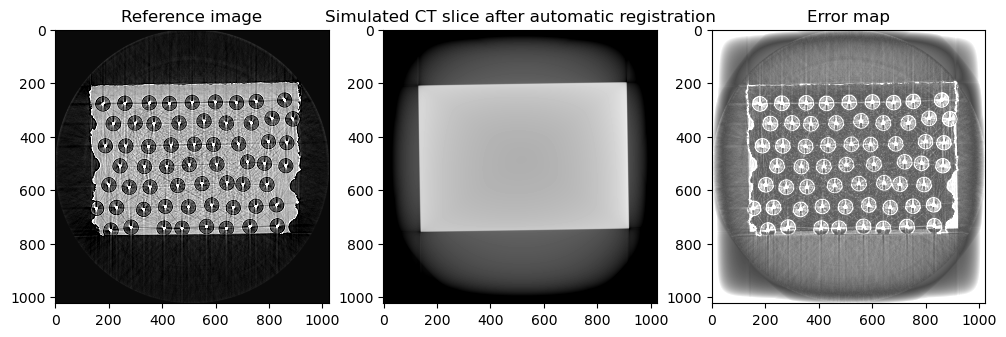

In [85]:
norm = cm.colors.Normalize(vmax=1.25, vmin=-0.5)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
# fig.suptitle('Horizontally stacked subplots')

ax1.set_title("Reference image");
imgplot1 = ax1.imshow(normalised_reference_CT, cmap="gray", 
                     norm=norm);

ax2.set_title("Simulated CT slice after automatic registration");
imgplot2 = ax2.imshow(registration_image[0],
                     cmap='gray',
                     norm=norm);

ax3.set_title("Error map");
imgplot3 = ax3.imshow(np.abs(registration_image[0] - normalised_reference_CT),
                     cmap='gray',
                     norm=norm);

# fig.colorbar(imgplot2);


## Find circles

We can use the Hoguh transform to detect where circles are in the image. However, the input image in OpenCV's function must be in UINT8. We blur it using a bilateral filter (an edge-preserving smoothing filter).

### Convert the image to UINT8

In [87]:
temp_reference = copy.deepcopy(g_reference_CT);
temp_reference -= np.min(g_reference_CT);
temp_reference /= np.max(g_reference_CT);
temp_reference *= 255;
temp_reference = temp_reference.astype(np.uint8);

blur = cv2.bilateralFilter(temp_reference, 9, 75, 75);
np.savetxt("Tutorial2/outputs/reference_CT-blurred.mha", blur);

### Apply the Hough transform

In [88]:
circles = cv2.HoughCircles(temp_reference, cv2.HOUGH_GRADIENT, 2, 80,
                            param1=250, param2=15, minRadius=5, maxRadius=10);

### Overlay the detected circles on the top of the image

In [89]:
cimg = cv2.cvtColor(blur, cv2.COLOR_GRAY2BGR);
circles = np.uint16(np.around(circles));

for i in circles[0,:]:
    
    # draw the outer circle
    cv2.circle(cimg,(i[0],i[1]),i[2],(0,255,0),2);
    
    # draw the center of the circle
    cv2.circle(cimg,(i[0],i[1]),2,(0,0,255),3);

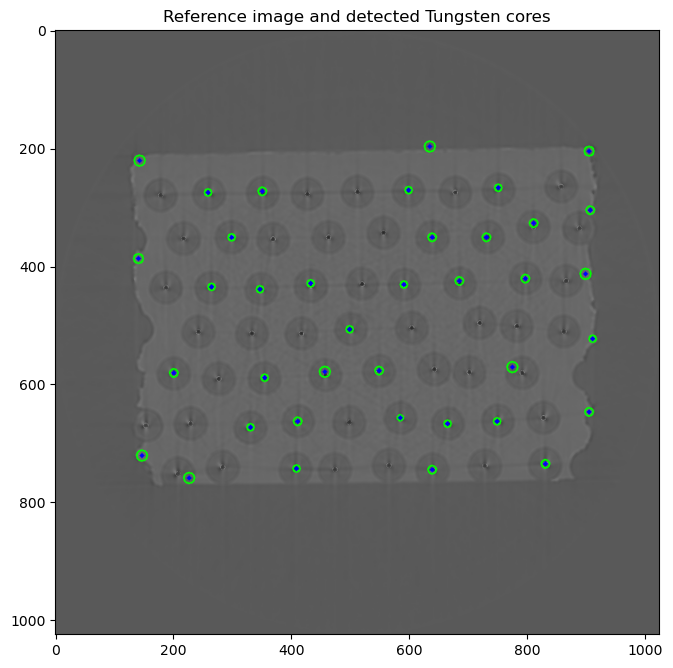

In [90]:
fig=plt.figure();
imgplot = plt.imshow(cimg);
plt.title("Reference image and detected Tungsten cores");